In [1]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

import pandas as pd
from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
"""
datapath='/media/peter/storage/data/geneexpression/Network_1/Network_1_Configuration_1_knockouts.tsv'
df = pd.read_csv(datapath, delimiter='\t')
knockouts = df.as_matrix()

datapath='/media/peter/storage/data/geneexpression/Network_1/Network_1_Configuration_1_wildtype.tsv'
df = pd.read_csv(datapath, delimiter='\t')
wildtype = df.as_matrix()

genes = np.vstack([wildtype[:,0:-1], knockouts[:,0:-1]])

"""

datapath='/media/peter/storage/data/geneexpression/opticlobe/geneExpressionMatrix_20151118.txt'
df = pd.read_table(datapath, delimiter='\t')

In [3]:
name = list(df)
tpm_index = []
for k in range(len(name)):
    if 'tpm' in name[k]:
        tpm_index.append(k)

In [4]:
num_genes, num_data = df.shape
num_data = len(tpm_index)
gene_expression = np.zeros((num_data, num_genes))
for i in range(num_genes):
    gene_expression[:,i] = df.iloc[i][tpm_index]


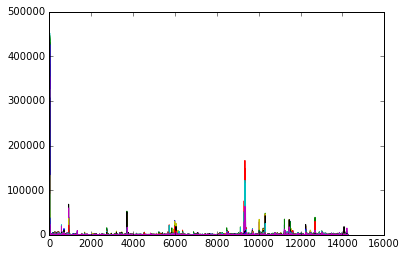

In [6]:
plt.figure()
plt.plot(gene_expression.T);

In [38]:
norm_expression = []
for i in range(num_genes):
    expression = gene_expression[:,i]
    MEAN = np.mean(expression)
    STD = np.std(expression)
    if STD > 0:
        norm_expression.append((expression - MEAN)/STD)

In [44]:
norm_expression = np.array(norm_expression).T

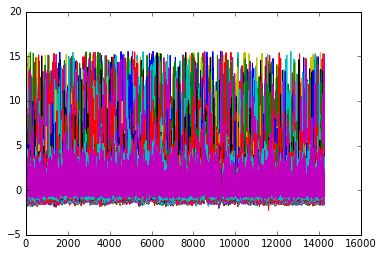

In [45]:
plt.figure()
plt.plot(norm_expression.T);

In [57]:
num_data, num_genes = norm_expression.shape

num_train = 200
indices = np.arange(num_data)
np.random.shuffle(indices)
X_train = norm_expression[indices[:num_train],:]
X_valid = norm_expression[indices[num_train:],:]

In [58]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [59]:
num_encode=50
num_units1=1000
num_units2 = 500

input_var = T.dmatrix('inputs')
shape = (None, num_genes)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = layers.DenseLayer(net['input'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode2'] = layers.DenseLayer(net['encode1'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['encode_mu'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])

net['decode1'] = layers.DenseLayer(net['Z'], num_units=num_units2, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['decode2'] = layers.DenseLayer(net['decode1'], num_units=num_units1, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.softplus)
net['X'] = layers.DenseLayer(net['decode2'], num_units=num_genes,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.sigmoid)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])

In [60]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean()
train_loss = build_loss(net, input_var, deterministic=False)
test_loss = build_loss(net, input_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss , updates=update_op)
valid_fun = theano.function([input_var], test_loss)

def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        

In [61]:
num_epochs = 60
batch_size = 10
num_train_batches = X_train.shape[0] // batch_size
num_valid_batches = X_valid.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)
    valid_batches = batch_generator(X_valid, batch_size, shuffle=False)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    valid_loss = 0
    for index in range(num_valid_batches):
        loss = valid_fun(next(valid_batches))
        valid_loss += loss

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss/num_valid_batches))

Epoch 1 of 60
  training loss:		460511766696916877312.000000
  validation loss:		13500133.004587
Epoch 2 of 60
  training loss:		707982395.519033
  validation loss:		177278.801575
Epoch 3 of 60
  training loss:		189802.100380
  validation loss:		166936.262421
Epoch 4 of 60
  training loss:		194154.932878
  validation loss:		172394.243850
Epoch 5 of 60
  training loss:		6265642.474026
  validation loss:		170235.179278
Epoch 6 of 60
  training loss:		12188530.344121
  validation loss:		674508.532183
Epoch 7 of 60
  training loss:		7429108.637436
  validation loss:		763097.010506
Epoch 8 of 60
  training loss:		12957813.047102
  validation loss:		2486781.637417
Epoch 9 of 60
  training loss:		20654275.038901
  validation loss:		27276167.970268
Epoch 10 of 60
  training loss:		9874535.714908
  validation loss:		305751.851460
Epoch 11 of 60
  training loss:		325321.583887
  validation loss:		835845.480006
Epoch 12 of 60
  training loss:		4786796.919174
  validation loss:		3883705.294037
Epo

KeyboardInterrupt: 

In [ ]:
def statistics(net, target_var):
    z_mu = get_output(net['encode_mu'], deterministic=True)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=True)
    x_mu = get_output(net['X'], deterministic=True)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma))
    log_likelihood = -0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma)
    return kl_divergence, log_likelihood
kl_divergence, log_likelihood = statistics(net, input_var)

statistics_fun = theano.function([input_var],[kl_divergence, log_likelihood])

In [ ]:
batch_size = 25
num_test_batches = X_valid.shape[0] // batch_size
test_batches = batch_generator(X_valid, batch_size, shuffle=False)

kldiv = []
logL = []
for index in range(num_test_batches):
    stats = statistics_fun(next(test_batches))
    kldiv.append(stats[0])
    logL.append(stats[1])

kldiv = np.array(kldiv).reshape([-1,stats[0].shape[1]])
logL = np.array(logL).reshape([-1,stats[1].shape[1]])

In [ ]:
plt.figure
plt.errorbar(range(num_encode),-np.mean(kldiv,axis=0),np.std(kldiv,axis=0), fmt='o', markersize=12)
plt.xlim([-.3, num_encode-.7])
plt.xlabel('z', fontsize=18)
plt.ylabel('-KLD', fontsize=18)
#plt.yticks([0, 1, 2, 3], fontsize = 18)
plt.xticks(fontsize = 18)
plt.savefig('Genes_vae_kldivergence_'+ str(num_encode) +'.eps', format='eps', dpi=200)